## Unzipping the dataset

The dataset after the generating augmentations is unzipped and loaded.

In [6]:
cd /content/drive/MyDrive/NNDLProject

/content/drive/MyDrive/NNDLProject


In [ ]:
!unzip mcdondalds_food_items_dataset.zip

Archive:  mcdondalds_food_items_dataset.zip
   creating: images/
  inflating: images/001.jpg          
  inflating: images/067.JPG          
  inflating: images/081203-134216.jpg  
  inflating: images/10128483542.jpg  
  inflating: images/1060040027_0000000675_5.jpg  
  inflating: images/1060586881_0000049050_1.jpg  
  inflating: images/11151724.JPG_type=w773.jpg  
  inflating: images/12790b52.jpg     
  inflating: images/130831-17lunch.jpg  
  inflating: images/13158234033_5f2e124485_z.jpg_resize=640_2C426_ssl=1.jpg  
  inflating: images/1477569231383-largejpg.jpg  
  inflating: images/1861843D50BEB07B1F.jpg  
  inflating: images/20070119153816.jpg  
  inflating: images/2009-12-22_17-33-41.jpg  
  inflating: images/20101208_1558260.jpg  
  inflating: images/20110304-01.jpg  
  inflating: images/20120901-6065-Thumb.jpg  
  inflating: images/20130822-8268-Thumb.jpg  
  inflating: images/20140602_053955214_iOS.jpg  
  inflating: images/20140828-03.jpg  
  inflating: images/20150214131911

## Data Analysis

In [10]:
import os
import imageio
import matplotlib.pyplot as plt
import statistics
import numpy as np
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow
import torch
import torchvision.transforms.functional as f
from PIL import Image
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [8]:
REL_IMG_FOLDER_PATH = 'images/'

In [56]:
REL_IMG_PATH_LIST = []
for path in os.listdir(REL_IMG_FOLDER_PATH):
    if os.path.isfile(os.path.join(REL_IMG_FOLDER_PATH, path)):
        REL_IMG_PATH_LIST.append(path)
print('First 5 paths:', REL_IMG_PATH_LIST[:5], '\n', 'Total Length:', len(REL_IMG_PATH_LIST))

First 5 paths: ['5037754c4e8f4a54aaf8693d1a90443a_th_1.png', '20221010_013803_0.png', '20221010_013803_1.png', '20221010_013803_2.png', '20221010_013803_3.png'] 
 Total Length: 3550


There are a total of **3550** images in the dataset. Note that the size of dataset before augmentations was **355**, so there is a 10x increase from this step. We choose data analysis on the augmented data since this is the final data that will used by all of our 3 models, and we therefore wish to know the characteristics of this data.

### Visualisation of Images

In this section, we make a 8x8 grid of randomly sampled images from our dataset. This gives us a flavour of what kinds of images make up our dataset

In [58]:
from PIL import Image
import random
idxs = random.sample(range(0, 3550), 64)
paths_list = [REL_IMG_PATH_LIST[i] for i in idxs]
images = [Image.open(REL_IMG_FOLDER_PATH + f) for f in paths_list]

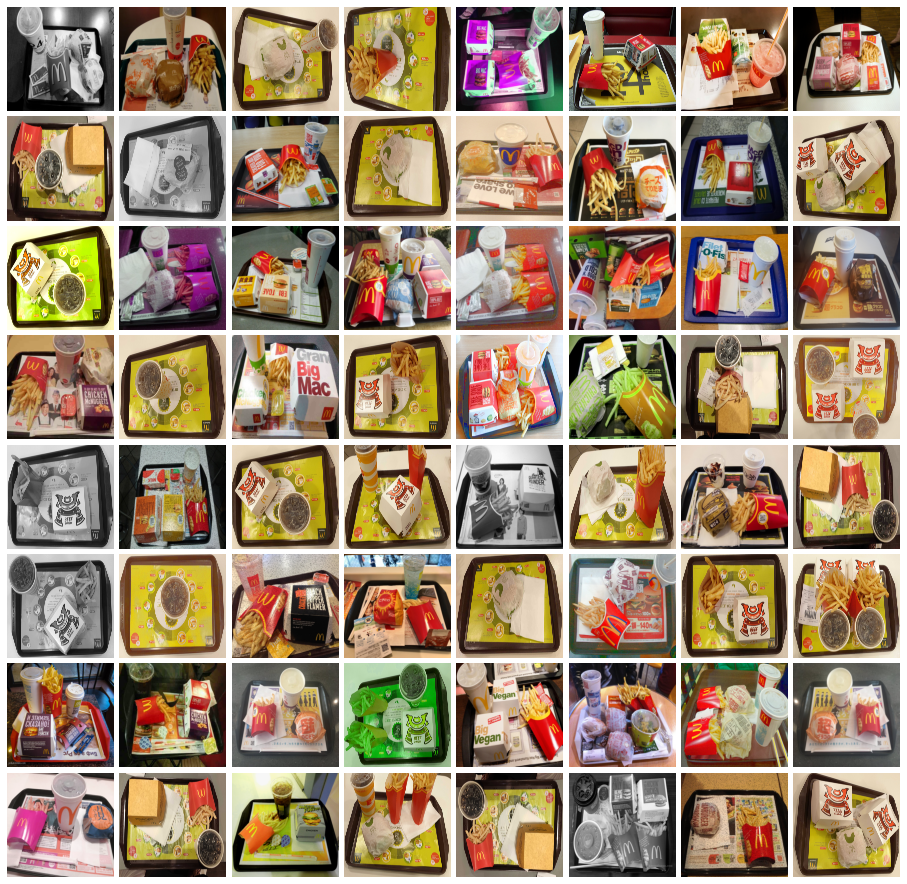

In [59]:
max_rows, max_cols = 8, 8
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(16,16))
for idx, image in enumerate(images):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
    axes[row, col].imshow(image, cmap="gray", aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

As we can see, there are images from different angles (like side angles), grayscale images, and even randomly colored images (like greenish and purplish). Even though the model might never encounter situations like side angles and different colors, training our model on such data makes it resilient.

- For instance, the grayscale images have no color information, to decrease the model's reliance on color to determine the classes.

- The upside down, rotated and sided view images mean that the model can work even if the tray is not placed in the desired configuration.

### Image Height and Width Analysis

In [5]:
HEIGHTS_LIST, WIDTHS_LIST = [], []
for file in REL_IMG_PATH_LIST:
  img = imageio.imread(REL_IMG_FOLDER_PATH + file)
  shape = img.shape
  height, width = shape[0], shape[1]
  HEIGHTS_LIST.append(height)
  WIDTHS_LIST.append(width)

In [8]:
average_height = statistics.mean(HEIGHTS_LIST)
average_width = statistics.mean(WIDTHS_LIST)
std_height = statistics.variance(HEIGHTS_LIST)
std_width = statistics.variance(WIDTHS_LIST)

In [13]:
print("[Average Height]", "%.2f" % average_height, "[Average Width]", "%.2f" % average_width)

[Average Height] 1240.59 [Average Width] 1803.39


As we can see, the average height of the images is **1241** pixels and the average width is approximately **1803** pixels approximately. Therefore, our images have an approximate aspect ratio of **7:10**. In the below section, we make violin plots to understand the image sizes better.

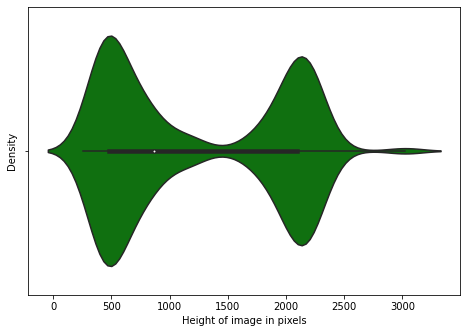

In [43]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.violinplot(HEIGHTS_LIST, color = 'green')
ax.set_ylabel('Density')
ax.set_xlabel('Height of image in pixels');

From above, the violin plot suggests that the distribution of heights is bimodal, with peaks at approximately 500 and 2100 pixel sizes. Among these 2, there are more images in the 500 region. There also seems to a small third peak at around 3100 region.

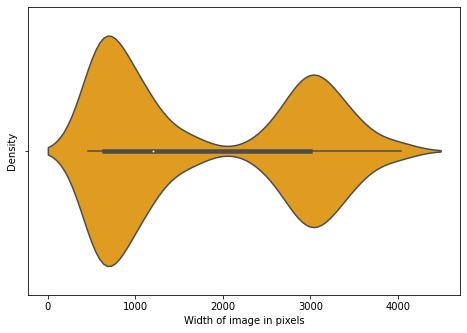

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.violinplot(WIDTHS_LIST, color = 'orange')
ax.set_ylabel('Density')
ax.set_xlabel('Width of image in pixels');

The violin plot of widths is also bimodal with peaks around 700 and 3000 region. There are no such outliers in this plot.

**Inference:** From the height and width violin plots, we notice 2 separate distributions of images - images with sizes of approximately **(500 x 700**) and **(2100 x 3000**). And these values closely follow the average aspect ratio we observed before (**7:10**). The reason for bimodal distribution is because we sourced our data from 2 methods - our own pictures from visits to a Mc Donald's store, and, scraped data from the internet.  

### Per Channel Mean and Standard Deviation Of Dataset

Reference: [https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html](https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html)

In [91]:
len_ds = len(REL_IMG_PATH_LIST)

In [92]:
resize_dim = (224, 224)
ds_mean = torch.tensor([0., 0., 0.])
ds_std = torch.tensor([0., 0., 0.])
for file in REL_IMG_PATH_LIST:
  img = Image.open(REL_IMG_FOLDER_PATH + file)
  img_tensor = f.to_tensor(img)
  r_mean, r_std = img_tensor[0].mean(), img_tensor[0].std()
  g_mean, g_std = img_tensor[1].mean(), img_tensor[1].std()
  b_mean, b_std = img_tensor[2].mean(), img_tensor[2].std()
  ds_mean += torch.tensor([r_mean, g_mean, b_mean])
  ds_std += torch.tensor([r_std, g_std, b_std])
  #cv2_imshow(np.moveaxis(img_tensor.detach().numpy(), 0, -1)[...,::-1]* 255)

In [93]:
ds_mean /= len_ds
ds_std /= len_ds

In [94]:
print(ds_mean, ds_std)

tensor([0.5757, 0.4812, 0.3823]) tensor([0.2565, 0.2641, 0.2604])


From the calculations, we observe that the channel-wise mean for `[R, G, B]` channels is: **`[0.5757, 0.4812, 0.3823]`**

Channel-wise average standard deviation for `[R, G, B]` channels is: **`[0.2565, 0.2641, 0.2604]`**. 

We observe that the standard deviations are similar and from the mean values, it is inferred that the images are mostly orange-to-yellow in color. This is because the packacking in McD is in red and yellow, and the fries that are open (not closed in packaging) are golden yellow in color).

Reference: [https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935](https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935)

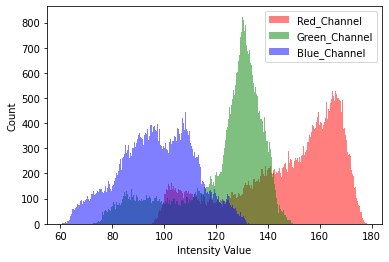

In [95]:
from skimage import io
import matplotlib.pyplot as plt
from cv2 import resize

red = np.zeros(50176)
green = np.zeros(50176)
blue = np.zeros(50176)

for file in REL_IMG_PATH_LIST:
  image = io.imread(REL_IMG_FOLDER_PATH + file)
  image = resize(image, (224, 224))
  red += image[:, :, 0].ravel()
  green += image[:, :, 1].ravel()
  blue += image[:, :, 2].ravel()

red /= len_ds
blue /= len_ds
green /= len_ds

_ = plt.hist(red, bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(green, bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(blue, bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

A histogram plot was also made for the aggregate of the entire dataset, and this shows the per-channel histogram plot for every pixel value (0-255). Unlike a single average value, this plot shows us more information.

We see that the blue channel follows a close to **normal curve**. But the red and green channels are **skewed** to the right. This information is not captured in the standard deviation value (which showed similar behaviour for all 3 channels).

### Number of instances of each class in the dataset images

In this section, we count the number of individual instances of each class object in our entire dataset. This means that say there are 3 burgers in an image, all of them will be added to our count.

In [15]:
from ast import literal_eval
import pandas as pd
DF_RAW = pd.read_csv('df2.csv',usecols=[
                         'filename', 'bbox_label'], converters={'bbox_label': literal_eval})
print(DF_RAW.head())

                               filename  \
0                   20221010_014411.jpg   
1                   20221010_020330.jpg   
2           8516899477_1d24501f20_b.jpg   
3         mcdonaldsburgermeal15jpg.jpeg   
4  o1200090014069961558.jpg_caw=800.jpg   

                                          bbox_label  
0                         [(1216, 0, 2623, 1266, 1)]  
1  [(1581, 8, 2297, 623, 2), (1117, 729, 2086, 19...  
2  [(291, 72, 584, 353, 1), (332, 306, 626, 626, ...  
3  [(158, 328, 546, 671, 1), (588, 17, 875, 373, ...  
4  [(482, 130, 714, 397, 3), (66, 196, 312, 423, ...  


In [ ]:
counts = [0, 0, 0]

In [ ]:
for index, row in DF_RAW.iterrows():
    bboxes = row['bbox_label']
    for bbox in bboxes:
      cls = bbox[-1]
      counts[cls-1] +=1 

In [ ]:
counts

[4330, 3690, 3640]

From the calculations, we observe the following, 

| Item     | Count |
| ----------- | ----------- |
| Burger     | 4330      |
| Drink  | 3690       |
| Fries  | 3640       |

We see that the burgers are the majority with almost 1000 more instances than the other 2. But, drinks and fries are almost the same in count of instances. However, overall, the dataset is balanced among all 3 classes. Therefore, we do not run into a risk of overfitting for any particular class.

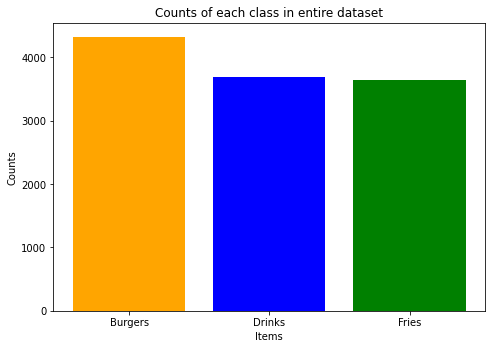

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
items = ['Burgers', 'Drinks', 'Fries']
counts = [4330, 3690, 3640]
color = ['orange', 'blue', 'green']
ax.bar(items, counts, color = color)
ax.set_ylabel('Counts')
ax.set_xlabel('Items')
ax.set_title('Counts of each class in entire dataset')
plt.show()

Above is the bar graph visualisation of the same. This makes it easier to view the balance.

### Area taken by objects in the images

In this section, we are interested in finding out what percent of image is taken up by each class on average. Note that we do not take the intersection of areas into account. Therefore, this estimate is an overestimate. We perform this exercise to get an idea of how well the objects in our dataset cover the entire image.

In [7]:
from ast import literal_eval
import pandas as pd
DF_RAW = pd.read_csv('df2.csv',usecols=[
                         'filename', 'bbox_label'], converters={'bbox_label': literal_eval})
print(DF_RAW.head())

                               filename  \
0                   20221010_014411.jpg   
1                   20221010_020330.jpg   
2           8516899477_1d24501f20_b.jpg   
3         mcdonaldsburgermeal15jpg.jpeg   
4  o1200090014069961558.jpg_caw=800.jpg   

                                          bbox_label  
0                         [(1216, 0, 2623, 1266, 1)]  
1  [(1581, 8, 2297, 623, 2), (1117, 729, 2086, 19...  
2  [(291, 72, 584, 353, 1), (332, 306, 626, 626, ...  
3  [(158, 328, 546, 671, 1), (588, 17, 875, 373, ...  
4  [(482, 130, 714, 397, 3), (66, 196, 312, 423, ...  


In [47]:
ratio_burger = []
ratio_drinks = []
ratio_fries = []
for index, row in DF_RAW.iterrows():
    curr_area = [0, 0, 0]
    fpath = row['filename']
    image = Image.open(REL_IMG_FOLDER_PATH + fpath)
    bboxes = row['bbox_label']
    img_array = np.array(image)
    img_dim = img_array.shape[:-1]
    img_area = img_dim[0] * img_dim[1]
    for bbox in bboxes:
      x0, y0, x1, y1, cls = bbox
      area = (x1 - x0) * (y1 - y0)
      curr_area[cls-1] += area
    print(curr_area)
    ratio_burger.append(curr_area[0]/img_area)
    ratio_drinks.append(curr_area[1]/img_area)
    ratio_fries.append(curr_area[2]/img_area)
    if index == 2:
      break

[1781262, 0, 0]
[2759913, 1591512, 2366876]
[176413, 84840, 144248]


In [49]:
ratio_burger = np.array(ratio_burger)
ratio_drinks = np.array(ratio_drinks)
ratio_fries = np.array(ratio_fries)

In [52]:
print(np.mean(ratio_burger[ratio_burger != 0]))

0.2776371379942643


In [53]:
print(np.mean(ratio_drinks[ratio_drinks != 0]))

0.16315164187434283


In [54]:
print(np.mean(ratio_fries[ratio_fries != 0]))

0.25412881422235767


Therefore, on average, burgers take up 27.76% of image's area, drinks take up 16.31% and fries take up 25.41%. 

| Item     | Percentage of cover |
| ----------- | ----------- |
| Burger     | 27.76%      |
| Drink  | 16.31%       |
| Fries  | 25.41%      |
|Total   | 69.48% |

We notice that overall, the classes take up aroun 69% of the image, which is a good enough cover. We also notice that burgers and fries take up a larger spread, while drinks take up a lower spread. This is because usually, mutiple burgers and fries are ordered in a serving while drinks are mostly single instance.

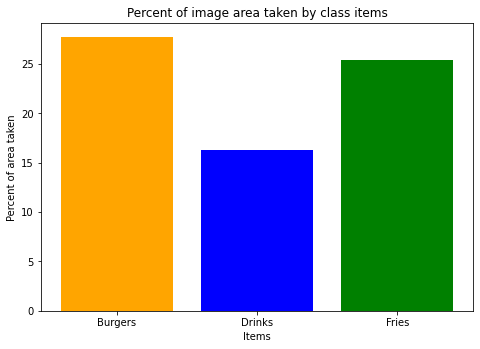

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
items = ['Burgers', 'Drinks', 'Fries']
counts = [27.76, 16.31, 25.41]
color = ['orange', 'blue', 'green']
ax.bar(items, counts, color = color)
ax.set_ylabel('Percent of area taken')
ax.set_xlabel('Items')
ax.set_title('Percent of image area taken by class items')
plt.show()

The above is a bar graph plot the above observation, which makes the observed disparity in drinks even more evident.